<a href="https://colab.research.google.com/github/MariaZharova/Skillfactory_projects/blob/main/2nd_year/CV-5_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5






## Импорт библиотек

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install tensorboard
!pip install -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 14.9 MB/s eta 0:00:00


In [ ]:
!pip install pillow

In [ ]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями и построения модели
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import shutil
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display
import zipfile

import yaml
import os
import random
from os import listdir
from os.path import isfile, join
from IPython.display import Image, display
from PIL import Image


In [ ]:
%matplotlib inline

## Загрузка данных

In [ ]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

In [ ]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Конвертация прошла успешно.')

100%|██████████| 3503/3503 [00:00<00:00, 13072.40it/s]


Конвертация прошла успешно.


In [ ]:
#xml_df = xml_df[:100]

In [ ]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_001960.jpg,3,375,500,sofa,1,131,500,374
1,2010_001960.jpg,3,375,500,person,1,59,500,375
2,2010_001960.jpg,3,375,500,person,249,30,473,251
3,2010_002947.jpg,3,333,500,aeroplane,128,179,375,254
4,2010_000137.jpg,3,500,333,bottle,32,116,228,500


In [ ]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 7760
Количество изображений в датафрэйме 3503


## Обработка данных

Закодируем классы обьектов.

In [ ]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [ ]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_001960.jpg,3,375,500,17,1,131,500,374
1,2010_001960.jpg,3,375,500,14,1,59,500,375
2,2010_001960.jpg,3,375,500,14,249,30,473,251
3,2010_002947.jpg,3,333,500,0,128,179,375,254
4,2010_000137.jpg,3,500,333,4,32,116,228,500


Сохраним кодировку классов в переменной mapping.

In [ ]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [ ]:
mapping

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

Теперь нам нужно привести наши данные к формату **YOLOv5**.

Аннотация каждого объекта должна сожержать следующую информацию:

`Class X Y Width Height`

![picture](https://drive.google.com/uc?export=view&id=1yUJt5XTvYo4MbWxKAxhPdCk-yCnQ1AEz)


Для этого воспользуемся вспомогательной функцией `convert_to_yolov5`.



In [ ]:
def convert_to_yolov5(df, unique_img_names):

    df_array = np.array(df)

    # Для каждого объкта
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        print(point)
        img_name = point[0]

        # Для каждого уникального изображения
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:
              class_id = point[4]

              # Преобразуем координаты bbox
              X = (point[5] + point[7]) / 2
              Y = (point[6] + point[8]) / 2
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])

              # Нормализуем координаты
              image_c, image_w, image_h = point[1], point[2], point[3]
              X /= image_w
              Y /= image_h
              Width    /= image_w
              Height   /= image_h

              # Запишем информацию о bbox в файл
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))

        # Дадим имя файлам, которые хотим сохранить
        save_file_name = os.path.join("VOCdevkit/VOC2012/JPEGImages/", img_name.replace("jpg", "txt"))

        # Сохраним аннотации на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Для начала выделим список уникальных имен изображений
unique_img_names = xml_df['filename'].unique()
print(len(unique_img_names))

3503


In [ ]:
# Получим аннотации в новом формате
convert_to_yolov5(xml_df, unique_img_names)

Streaming output truncated to the last 5000 lines.
['2010_006032.jpg' 3 334 500 0 1 1 500 334]
['2010_004879.jpg' 3 500 328 8 142 295 199 400]
['2010_004879.jpg' 3 500 328 14 1 256 26 334]
['2010_005359.jpg' 3 375 500 13 56 1 500 375]
['2010_002638.jpg' 3 375 500 0 22 81 500 260]
['2010_002638.jpg' 3 375 500 0 299 166 473 197]
['2010_006735.jpg' 3 500 375 14 79 329 375 500]
['2010_004824.jpg' 3 500 375 6 139 291 345 382]
['2010_001785.jpg' 3 375 500 10 64 181 440 375]
['2010_001785.jpg' 3 375 500 4 314 132 342 204]
['2010_001785.jpg' 3 375 500 4 248 184 294 260]
['2010_001785.jpg' 3 375 500 4 228 207 253 251]
['2010_001785.jpg' 3 375 500 14 400 109 500 375]
['2010_001785.jpg' 3 375 500 14 1 107 183 375]
['2010_001785.jpg' 3 375 500 14 34 59 215 227]
['2010_001785.jpg' 3 375 500 4 46 1 61 32]
['2010_001785.jpg' 3 375 500 4 32 1 47 32]
['2010_001785.jpg' 3 375 500 4 9 1 30 34]
['2010_001785.jpg' 3 375 500 15 301 133 376 204]
['2010_001851.jpg' 3 375 500 10 142 216 273 350]
['2010_001851.

Давайте протестируем трансформированные аннотиции с помощью визуализации.

In [ ]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))

In [ ]:
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")


    plt.imshow(np.array(image))
    plt.show()

In [ ]:
# Выберем рандомную аннотацию
annotation_random= !ls VOCdevkit/VOC2012/JPEGImages/*txt | shuf -n 1

In [ ]:
annotation_random

['VOCdevkit/VOC2012/JPEGImages/2010_003421.txt']

[[14.     0.668  0.376  1.331  0.748]]


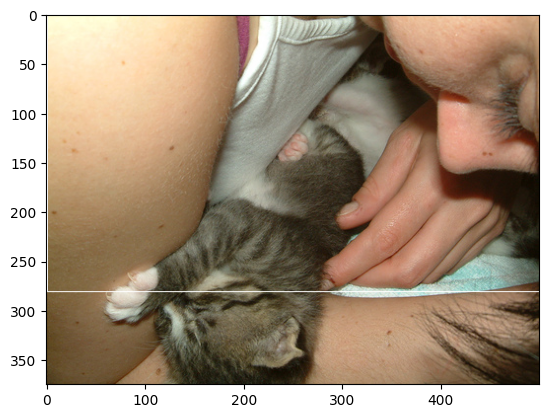

In [ ]:
# Выберем рандомную аннотацию
annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Обученная модель находится в классе hub библиотеки `torch`.

Давайте посмотрим на предсказания модели для нашей рандомной картинки.

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

img = annotation_random[0].replace("txt", "jpg")

# Inference
results = model(img)

# Results
results.print()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 25.4 MB/s eta

## ЗАДАНИЕ

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

In [ ]:
def make_annotations(xml_file, xml_list, images_path):
  # print(f"Processing file {xml_file}")
  # check does exist image file for specified xml file
  image_path = os.path.join(images_path,
                            os.path.basename(xml_file).replace(".xml", ".jpg"))

  if os.path.exists(image_path):
    # image exists - read annotations
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for obj in root.findall('object'):
        bbx = obj.find('bndbox')
        xmin = float(bbx.find('xmin').text)
        ymin = float(bbx.find('ymin').text)
        xmax = float(bbx.find('xmax').text)
        ymax = float(bbx.find('ymax').text)
        label = obj.find('name').text

        value = (root.find('filename').text,
                  float(root.find('size').find('depth').text),
                  float(root.find('size').find('width').text),
                  float(root.find('size').find('height').text),
                  label,
                  xmin,
                  ymin,
                  xmax,
                  ymax
                  )
        xml_list.append(value)



In [ ]:
# read annotations files list
csv_file = "VOC.csv"
if not os.path.exists(csv_file):
  annotations_folder = "VOCdevkit/VOC2012/Annotations"
  annotations = [f for f in listdir(annotations_folder) if isfile(join(annotations_folder, f))]
  xml_list = []

  for xml_file in tqdm(annotations):
    make_annotations(os.path.join(annotations_folder, xml_file),
                    xml_list, "VOCdevkit/VOC2012/JPEGImages")

  column_name = ['filename', 'channels', 'width', 'height',
                    'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  le = preprocessing.LabelEncoder()
  xml_df['class_converted'] = le.fit_transform(xml_df['class'])
  xml_df.head()

  # save to CSV file
  xml_df.to_csv('VOC.csv', index=None)

  print(f"Transformation completed and data saved to {csv_file}")
else:
  # read CSV file
  xml_df = pd.read_csv(csv_file)
  print(f"File {csv_file} already exists and reloaded!!! Skipping...")

xml_df.sort_values('filename')
xml_df.head(10)

100%|██████████| 17125/17125 [00:02<00:00, 7649.07it/s]


Transformation completed and data saved to VOC.csv


,filename,channels,width,height,class,xmin,ymin,xmax,ymax,class_converted
0,2008_001031.jpg,3.0,299.0,500.0,person,65.0,33.0,157.0,317.0,14
1,2008_001031.jpg,3.0,299.0,500.0,horse,60.0,138.0,214.0,500.0,12
2,2008_007334.jpg,3.0,344.0,500.0,sheep,1.0,144.0,170.0,462.0,16
3,2008_007334.jpg,3.0,344.0,500.0,person,106.0,60.0,286.0,458.0,14
4,2011_004111.jpg,3.0,332.0,500.0,person,4.0,28.0,332.0,500.0,14
5,2008_005147.jpg,3.0,500.0,375.0,bicycle,119.0,75.0,463.0,281.0,1
6,2008_005147.jpg,3.0,500.0,375.0,bicycle,397.0,47.0,463.0,75.0,1
7,2008_003793.jpg,3.0,500.0,371.0,person,312.0,194.0,500.0,371.0,14
8,2008_003793.jpg,3.0,500.0,371.0,person,226.0,182.0,362.0,371.0,14
9,2008_003793.jpg,3.0,500.0,371.0,person,153.0,168.0,308.0,371.0,14


In [ ]:
xml_df[xml_df['filename'] == '2007_000027.jpg'][['class','class_converted']]

,class,class_converted
4826,person,14


In [ ]:
unique_values = xml_df.drop_duplicates(subset=['class', 'class_converted'])
unique_values[['class', 'class_converted']]

,class,class_converted
0,person,14
1,horse,12
2,sheep,16
5,bicycle,1
10,sofa,17
13,motorbike,13
16,car,6
18,cat,7
36,aeroplane,0
37,diningtable,10


In [ ]:
def convert_to_yolo_format(csv_file, image_folder, output_folder, output_images_path, use_colored_images=True):
    df = pd.read_csv(csv_file)
    for index, row in tqdm(df.iterrows()):
        image_name = row['filename']
        class_label = row['class_converted']
        x_min, y_min, x_max, y_max = row['xmin'], row['ymin'], row['xmax'], row['ymax']

        image_path = os.path.join(image_folder, image_name)

        if os.path.exists(image_path):
          yolo_label_path = os.path.join(output_folder, image_name.replace(".jpg", ".txt"))

          dest_image_path = os.path.join(output_images_path, image_name)
          # print(f"Copy {image_path} to {dest_image_path}")
          if use_colored_images:
            # copy color image
            shutil.copy2(image_path, dest_image_path)
          else:
            # convert to grayscale image
            color_image = cv2.imread(image_path)
            grayscale_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(dest_image_path, grayscale_image)


          img_width, img_height = float(row['width']), float(row['height'])  # You should set the actual width and height of the image

          x_center = (x_min + x_max) / (2 * img_width)
          y_center = (y_min + y_max) / (2 * img_height)
          bbox_width = (x_max - x_min) / img_width
          bbox_height = (y_max - y_min) / img_height

          with open(yolo_label_path, 'w') as f:
              f.write(f"{class_label} {x_center} {y_center} {bbox_width} {bbox_height}\n")
        else:
          print(f"Image {image_path} not found!!!")

In [ ]:
VOCDevkit_path = "VOCdevkit/VOC2012"
csv_file_path = "VOC.csv"
image_folder_path = os.path.join(VOCDevkit_path, "JPEGImages")
output_folder_path = "data/labels"
output_images_path = "data/images"

if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

if not os.path.exists(output_images_path):
    os.makedirs(output_images_path)

convert_to_yolo_format(csv_file_path, image_folder_path, output_folder_path, output_images_path, False)

40138it [05:39, 118.28it/s]


In [ ]:
# make yaml file and generate classes mappings
unique_classes = xml_df['class'].unique()
class_num = 0
classes_list = {}
classes_mappings = {}

unique_values = xml_df.drop_duplicates(subset=['class', 'class_converted'])
unique_values = unique_values[['class', 'class_converted']]

unique_values.sort_values(by='class_converted')

for class_label in unique_values.iterrows():
    classes_list[class_label[1:2][0]['class_converted']] = class_label[1:2][0]['class']
    classes_mappings[class_label[1:2][0]['class']] = class_label[1:2][0]['class_converted']
    class_num += 1

yaml_file = "data/data.yaml"
yaml_content = {
    "train": "../data/train.txt",
    "val": "../data/val.txt",
    "nc": xml_df["class"].nunique(),  # Number of classes (change this according to your dataset)
    "names": classes_list,
    "logger": {
      "log_dir": "/yolov5_logs"
    },
    "model" : {
        "ch": 1
    }
}

with open(yaml_file, 'w') as f:
        yaml.dump(yaml_content, f)

In [ ]:
# split images into test and validation datasets
image_folder = "data/images"
label_folder = "data/labels"
validation_images = ""

# Get a list of all image files
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Split the dataset into train and validation sets (adjust test_size as needed)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Write the file paths to train.txt and val.txt
with open("data/train.txt", "w") as f:
    for file in train_files:
        f.write(os.path.join(image_folder, file) + "\n")

with open("data/val.txt", "w") as f:
    for file in val_files:
        f.write(os.path.join(image_folder, file) + "\n")

In [ ]:
# write classes to file
unique_classes = xml_df['class'].unique()

# Write the unique classes to the 'data/classes.txt' file
with open('data/class_names.txt', 'w') as f:
    class_num = 0
    for class_label in unique_classes:
        f.write(f"{class_num}: {class_label}" + '\n')
        class_num += 1

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5
#!ls
!pip install -r yolov5/requirements.txt
!pip install comet_ml

Cloning into 'yolov5'...
remote: Enumerating objects: 15927, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 15927 (delta 20), reused 26 (delta 9), pack-reused 15880
Receiving objects: 100% (15927/15927), 14.60 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (10919/10919), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.7/559.7 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.1/510.1 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client

In [ ]:
#from google.colab import drive


#!wget -O yolo_trained.tar "https://drive.google.com/uc?id=1BdEaq_6x2qfIHssR0PPditxTQgD-y9H3&confirm=t&uuid=a66cd725-fec0-47b1-be25-b63499af05a8"


# load pretrained model
if not os.path.exists("yolo_trained.tar"):
  # model trained on colored images
  # !wget -O yolo_trained.tar "https://drive.google.com/uc?id=1BdEaq_6x2qfIHssR0PPditxTQgD-y9H3&confirm=t&uuid=a66cd725-fec0-47b1-be25-b63499af05a8"

  # load model trained on black and white images
  !wget -O yolo_trained.tar "https://drive.google.com/u/0/uc?id=1515ViX2oUyueVmEK2lPUWltmzf6tnzvr&export=download&confirm=t&uuid=cab777ca-da82-4d4a-ad4f-e1031deaf453&at=AB6BwCAm7ZAcGkad90w9ia3H7VKJ:1692677974344"

  with tarfile.open("yolo_trained.tar") as tar:
    tar.extractall("yolov5/runs")

--2023-08-29 05:03:47--  https://drive.google.com/u/0/uc?id=1515ViX2oUyueVmEK2lPUWltmzf6tnzvr&export=download&confirm=t&uuid=cab777ca-da82-4d4a-ad4f-e1031deaf453&at=AB6BwCAm7ZAcGkad90w9ia3H7VKJ:1692677974344
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.102, 74.125.195.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1515ViX2oUyueVmEK2lPUWltmzf6tnzvr&export=download&confirm=t&uuid=cab777ca-da82-4d4a-ad4f-e1031deaf453&at=AB6BwCAm7ZAcGkad90w9ia3H7VKJ:1692677974344 [following]
--2023-08-29 05:03:48--  https://drive.google.com/uc?id=1515ViX2oUyueVmEK2lPUWltmzf6tnzvr&export=download&confirm=t&uuid=cab777ca-da82-4d4a-ad4f-e1031deaf453&at=AB6BwCAm7ZAcGkad90w9ia3H7VKJ:1692677974344
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-ag-docs.googleuserco

In [ ]:
%load_ext tensorboard

In [ ]:
# model already trained
# !python yolov5/train.py --data data/data.yaml --weights yolov5m.pt --img 416 --batch 16 --epochs 35 --name yolov5_trained --cfg yolov5/models/yolov5m.yaml

In [ ]:
# read results csv file
result_df = pd.read_csv("yolov5/runs/yolov5_trained_bw3/results.csv")
result_df.head()

,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,...,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
0,0,0.053825,0.019740,0.041732,0.38153,...,0.008215,0.017519,0.070018,0.003331,0.003331
1,1,0.042046,0.017024,0.020745,0.47270,...,0.008425,0.014801,0.039908,0.006555,0.006555
2,2,0.042575,0.017937,0.023374,0.37961,...,0.009288,0.022429,0.009688,0.009668,0.009668
3,3,0.045390,0.019124,0.028102,0.39477,...,0.009617,0.023612,0.009505,0.009505,0.009505
4,4,0.045500,0.019023,0.028016,0.34790,...,0.009690,0.022892,0.009505,0.009505,0.009505


In [ ]:
# Show epoch vs metrics/mAP_0.5
plt.figure(figsize=(10, 6))
plt.plot(result_df['               epoch'], result_df['     metrics/mAP_0.5'], marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('mAP_0.5')
plt.title('mAP_0.5 vs. Epoch')
plt.grid(True)
plt.show()

In [ ]:
def get_last_experiment():
  parent_directory = '/content/yolov5/runs/detect'
  subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]

  # Sort the subdirectories based on their creation timestamps in descending order
  subdirectories.sort(key=lambda d: os.path.getctime(os.path.join(parent_directory, d)), reverse=True)

  # Get the last created folder
  last_created_folder = subdirectories[0]

  # List all files within the last created folder
  last_created_folder_path = os.path.join(parent_directory, last_created_folder)
  folder_files = os.listdir(last_created_folder_path)

  # Sort the files based on their creation timestamps in descending order
  folder_files.sort(key=lambda f: os.path.getctime(os.path.join(last_created_folder_path, f)), reverse=True)

  # Get the last created file within the last created folder
  last_created_file = os.path.join(last_created_folder_path, folder_files[0])

  print("Last created folder:", last_created_folder)
  print("Last created file in the folder:", last_created_file)

  return last_created_file


data/images/2007_000241.jpg
detect: weights=['yolov5/runs/yolov5_trained_bw3/weights/best.pt'], source=data/images/2007_000241.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86301265 parameters, 0 gradients, 204.2 GFLOPs
image 1/1 /content/data/images/2007_000241.jpg: 320x416 2 boats, 83.6ms
Speed: 0.5ms pre-process, 83.6ms inference, 139.9ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp
Last created folder: exp
Last created file in the folder: /content/yolov

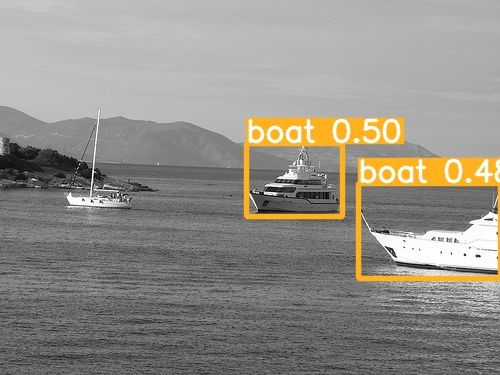

data/images/2012_002707.jpg
detect: weights=['yolov5/runs/yolov5_trained_bw3/weights/best.pt'], source=data/images/2012_002707.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86301265 parameters, 0 gradients, 204.2 GFLOPs
image 1/1 /content/data/images/2012_002707.jpg: 384x416 1 person, 93.0ms
Speed: 0.5ms pre-process, 93.0ms inference, 112.8ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp2
Last created folder: exp2
Last created file in the folder: /content/yo

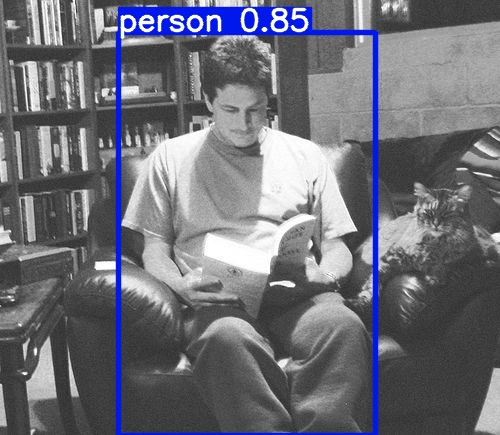

data/images/2008_000563.jpg
detect: weights=['yolov5/runs/yolov5_trained_bw3/weights/best.pt'], source=data/images/2008_000563.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86301265 parameters, 0 gradients, 204.2 GFLOPs
image 1/1 /content/data/images/2008_000563.jpg: 416x288 1 person, 51.4ms
Speed: 0.4ms pre-process, 51.4ms inference, 72.5ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp3
Last created folder: exp3
Last created file in the folder: /content/yol

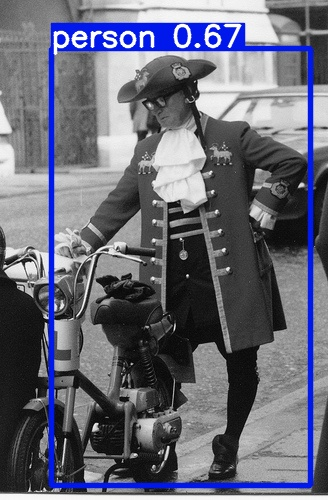

data/images/2008_007229.jpg
detect: weights=['yolov5/runs/yolov5_trained_bw3/weights/best.pt'], source=data/images/2008_007229.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86301265 parameters, 0 gradients, 204.2 GFLOPs
image 1/1 /content/data/images/2008_007229.jpg: 288x416 1 aeroplane, 77.4ms
Speed: 0.4ms pre-process, 77.4ms inference, 102.7ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp4
Last created folder: exp4
Last created file in the folder: /content

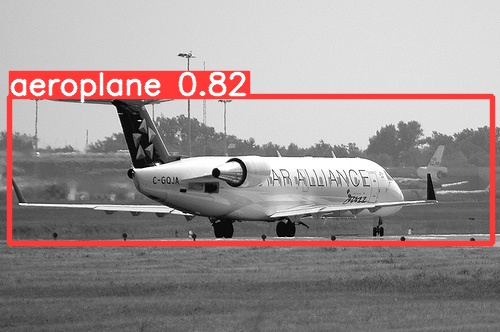

data/images/2010_001656.jpg
detect: weights=['yolov5/runs/yolov5_trained_bw3/weights/best.pt'], source=data/images/2010_001656.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5x summary: 322 layers, 86301265 parameters, 0 gradients, 204.2 GFLOPs
image 1/1 /content/data/images/2010_001656.jpg: 416x320 1 cat, 54.4ms
Speed: 0.4ms pre-process, 54.4ms inference, 80.8ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp5
Last created folder: exp5
Last created file in the folder: /content/yolov5

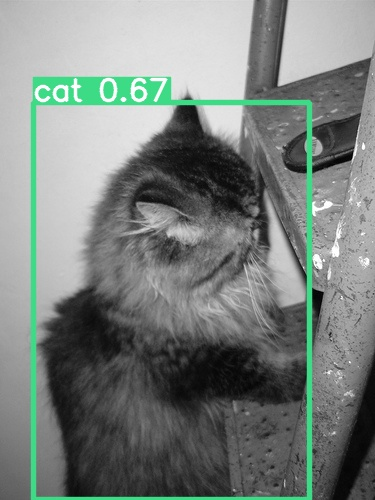

In [ ]:
# get random images and make prediction
#   read validation files list
file = open("data/val.txt", "r")
lines = file.readlines()

val_df = pd.DataFrame(data=lines, columns=['file_name'])
val_df['file_name'] = val_df['file_name'].apply(lambda x: x.replace("\n",""))

samples = val_df.sample(n=5)

for index in range(len(samples)):
   # Access the row data using iloc with the row index
  row = samples.iloc[index]
  print(row["file_name"])
  !python yolov5/detect.py --weights yolov5/runs/yolov5_trained_bw3/weights/best.pt --img 416 --conf 0.25 --source {row['file_name']}

  # get last created experiment file
  last_image = get_last_experiment()

  if os.path.exists(last_image):
    from google.colab.patches import cv2_imshow
    img = cv2.imread(last_image)
    cv2_imshow(img)

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.

In [ ]:
def make_annotations_frcnn(xml_folder, output_folder, class_mapping):

    os.makedirs(output_folder, exist_ok=True)

    for xml_file in tqdm(os.listdir(xml_folder)):
        if xml_file.endswith(".xml"):
            xml_path = os.path.join(xml_folder, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            image_filename = root.find("filename").text
            image_id = os.path.splitext(image_filename)[0]
            image_annotation_filename = f"{image_id}.txt"

            annotations = []
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name in class_mapping:
                    class_id = class_mapping[class_name]

                    xmin = int(round(float(obj.find("bndbox/xmin").text)))
                    ymin = int(round(float(obj.find("bndbox/ymin").text)))
                    xmax = int(round(float(obj.find("bndbox/xmax").text)))
                    ymax = int(round(float(obj.find("bndbox/ymax").text)))

                    annotations.append(f"{xmin},{ymin},{xmax},{ymax},{class_id}")

            if annotations:
                annotation_line = "\n".join(annotations)
                output_line = f"{annotation_line}"

                # Write to output file
                output_file_path = os.path.join(output_folder, image_annotation_filename)
                with open(output_file_path, "w+") as output_file:
                    output_file.write(output_line)


In [ ]:
# make annotations
make_annotations_frcnn("VOCdevkit/VOC2012/Annotations", "data/frcnn_labels", classes_mappings)

100%|██████████| 17125/17125 [00:09<00:00, 1728.35it/s]


In [ ]:
# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.transform = transform

        self.image_names = [filename for filename in os.listdir(image_folder) if filename.endswith(".jpg")]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(self.image_folder, image_name)
        annotation_path = os.path.join(self.annotation_folder, os.path.splitext(image_name)[0] + ".txt")

        image = Image.open(image_path).convert("RGB")
        images = []

        annotations = []
        if os.path.exists(annotation_path):
            with open(annotation_path, "r") as annotation_file:
                lines = annotation_file.readlines()
                annotations = [line.strip() for line in lines]

        boxes = []
        labels = []
        for annotation in annotations:
            parts = annotation.split(",")
            box = list(map(int, parts[:4]))
            class_id = int(parts[4])
            boxes.append(box)
            labels.append(class_id)

        if self.transform is not None:
            image = self.transform(image)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        return image, target

def custom_collate(batch):
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    # Ensure that all elements in the batch have the same number of annotations
    max_annotations = max(len(target) for target in targets)
    padded_targets = []

    for target in targets:
        while len(target) < max_annotations:
            target.append({
                "boxes": torch.tensor([0, 0, 0, 0], dtype=torch.float32),  # Dummy box
                "labels": torch.tensor([0], dtype=torch.int64)  # Dummy label
            })
        padded_targets.append(target)

    return images, padded_targets

In [ ]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(xml_df["class"].nunique())
num_epochs = 60
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

# Define the transformations to be applied to input images
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
])

# Create the dataset instance
dataset = CustomDataset("VOCdevkit/VOC2012/JPEGImages", "data/frcnn_labels", transform=transform)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:06<00:00, 24.3MB/s]


In [ ]:
with open("data/frcnn_labels/2011_000842.txt",'r') as ann_file:
  print(ann_file.readlines())

['1,66,173,375,14\n', '166,75,432,375,14']


In [ ]:
def train_frcnn(num_epochs, data_loader):
  total_loss = 0.0

  for epoch in range(num_epochs):
    model.train()
    i = 0
    epoch_loss = 0

    for imgs, annotations in tqdm(data_loader):
        i += 1
        #print(f"Images: {len(imgs)}, annotations: {len(annotations)}")
        # Make sure each image has a corresponding target
        assert len(imgs) == len(annotations), "Number of images and targets should match"
        imgs = list(img.to(device) for img in imgs)

        converted_annotations = [{
              "boxes": annotation["boxes"].to(device),
              "labels": annotation["labels"].to(device)
        } for annotation in annotations]

        # Forward pass and calculate loss
        loss_dict = model(imgs, converted_annotations)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    average_loss = epoch_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}, Images: {i}")

In [ ]:
# Create the dataset instance
dataset = CustomDataset("data/images", "data/frcnn_labels", transform=transform)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=custom_collate)

# model already trained and placed on
#train_frcnn(num_epochs, data_loader)

In [ ]:
# load trained model from google drive
!wget -O frcnn_trained.pth 'https://drive.google.com/u/0/uc?id=1IwYUoH-wXAVmUFEpPXdoPrUgSzptMDk1&export=download&confirm=t&uuid=00a8b5e8-e381-4f62-b175-901dc8c5c270&at=AB6BwCCba0TAWMH958CGQTbPNi0r:1693197235169'



--2023-08-29 05:05:03--  https://drive.google.com/u/0/uc?id=1IwYUoH-wXAVmUFEpPXdoPrUgSzptMDk1&export=download&confirm=t&uuid=00a8b5e8-e381-4f62-b175-901dc8c5c270&at=AB6BwCCba0TAWMH958CGQTbPNi0r:1693197235169
Resolving drive.google.com (drive.google.com)... 172.253.117.138, 172.253.117.100, 172.253.117.113, ...
Connecting to drive.google.com (drive.google.com)|172.253.117.138|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1IwYUoH-wXAVmUFEpPXdoPrUgSzptMDk1&export=download&confirm=t&uuid=00a8b5e8-e381-4f62-b175-901dc8c5c270&at=AB6BwCCba0TAWMH958CGQTbPNi0r:1693197235169 [following]
--2023-08-29 05:05:03--  https://drive.google.com/uc?id=1IwYUoH-wXAVmUFEpPXdoPrUgSzptMDk1&export=download&confirm=t&uuid=00a8b5e8-e381-4f62-b175-901dc8c5c270&at=AB6BwCCba0TAWMH958CGQTbPNi0r:1693197235169
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-ag-docs.googleus

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 219MB/s]


data/images/2010_001656.jpg


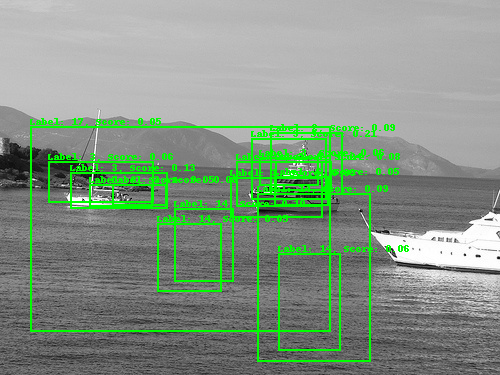

data/images/2007_000241.jpg


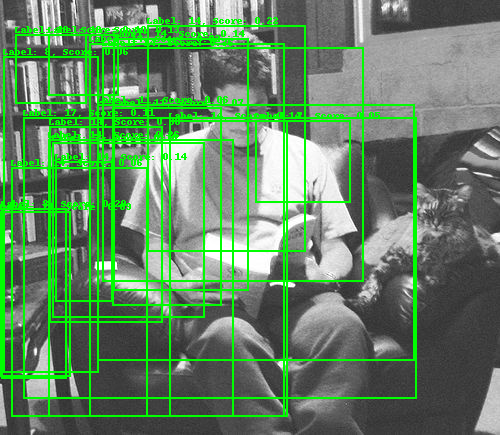

data/images/2012_002707.jpg


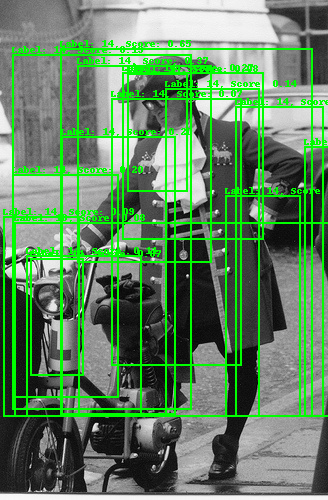

data/images/2008_000563.jpg


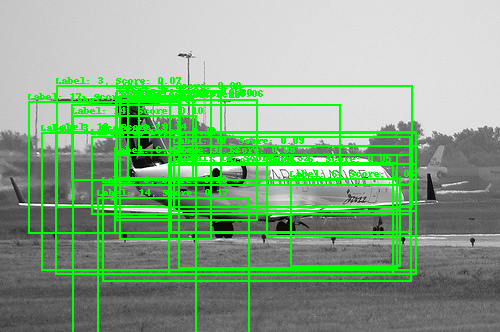

data/images/2008_007229.jpg


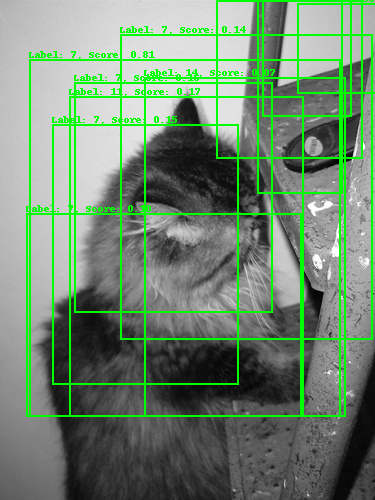

In [ ]:
checkpoint = torch.load("frcnn_trained.pth")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, xml_df["class"].nunique())

model.load_state_dict(checkpoint)


model.to(device)
model.eval()

# Use previously defined transformation
# Loop through the images and make predictions
for index in range(len(samples)):
    # show image file name
    print(row['file_name'])
    # Access the row data using iloc with the row index
    row = samples.iloc[index]
    # Load the image
    img = Image.open(row['file_name']).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        prediction = model(img_tensor)

    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    # Draw boxes and labels on the image
    img_draw = img.copy()
    draw = ImageDraw.Draw(img_draw)

    for box, label, score in zip(boxes, labels, scores):
        box = [int(coord) for coord in box]
        color = (0, 255, 0)  # Green color for the bounding box
        label_str = f"Label: {label}, Score: {score:.2f}"

        # Draw bounding box
        draw.rectangle([box[0], box[1], box[2], box[3]], outline=color, width=2)

        # Put label text above the bounding box
        draw.text((box[0], box[1] - 10), label_str, fill=color)

    # Convert PIL image to OpenCV format for display
    img_cv2 = cv2.cvtColor(np.array(img_draw), cv2.COLOR_RGB2BGR)

    # Display the image with predicted boxes and labels
    cv2_imshow(img_cv2)


#Выводы

Модель YOLO более точно онаруживает и классифицирует объекты на фотографиях, по сравнению с Faster R-CNN, которая в данном случае не определяет объекты вообще либо даётся слишком много прямоугольников с классами объектов.<br>
Также YOLO модель быстрее обучается (GPU NVIDIA GeForce RTX 3060 Laptop GPU) чем Faster R-CNN: YOLO 60 эпох обучалась около 7 часов, Faster R-CNN - более суток (см. [лог тренировок](https://drive.google.com/file/d/1z6ttGBdJbyzHylrhWrYHP1ZANCB46HtG/view?usp=sharing)).
